# Çalışan Kaybı (Attrition) Analizi ve Modelleme

Bu raporda, X Şirketi'nin çalışan kaybı problemini analiz etmek için veri bilimi adımlarını tek tek gösteriyoruz.

## 1️⃣ Veri Yükleme ve İlk Analiz
Veri setini yüklüyoruz ve genel özelliklerini inceliyoruz.

In [ ]:
import pandas as pd
df = pd.read_csv('data.csv')

print(df.head(10))
print(df.tail(5))

print(df.info())
print(df.describe())
print("Kolonlar ve veri tipleri:\n", df.dtypes)

missing_percent = df.isnull().mean() * 100
print("Eksik veri oranları (%):\n", missing_percent)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Sayısal verilerin özeti:\n", df[numeric_cols].describe())

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

print("Veri tipi dağılımı:\n", df.dtypes.value_counts())


   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   
5   32        No  Travel_Frequently       1005  Research & Development   
6   59        No      Travel_Rarely       1324  Research & Development   
7   30        No      Travel_Rarely       1358  Research & Development   
8   38        No  Travel_Frequently        216  Research & Development   
9   36        No      Travel_Rarely       1299  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8      

## 2️⃣ Hedef Değişkeni ve Özellikler
Attrition sütununu dönüştürüyoruz, kullanılmayacak sütunları çıkarıyoruz ve veri tiplerine göre ayırıyoruz.

In [3]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Kullanışsız/tek tip sütunlar çıkarılıyor
X = df.drop(columns=['Attrition', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'])
y = df['Attrition']

# Kategorik ve sayısal sütunları ayır
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Kategorik sütunlar:", categorical_cols)
print("Sayısal sütunlar:", numerical_cols)

# Sütunların veri tipleri
print("Sayısal sütun veri tipleri:\n", X[numerical_cols].dtypes)
print("Kategorik sütun veri tipleri:\n", X[categorical_cols].dtypes)

Kategorik sütunlar: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Sayısal sütunlar: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Sayısal sütun veri tipleri:
 Age                         int64
DailyRate                   int64
DistanceFromHome            int64
Education                   int64
EnvironmentSatisfaction     int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobSatisfaction             int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWo

## 3️⃣ Ön İşleme
Sayısal verileri ölçeklendiriyor, kategorik verileri One-Hot Encoding yapıyoruz.

In [ ]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

def show_heatmap(data):
    plt.figure(figsize=(16, 10))
    sns.heatmap(data.corr(), annot=True, cmap="Greens")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
show_heatmap(df)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

def add_features(X):
    X = X.copy()
    X['ManagerRatio'] = X['YearsWithCurrManager'] / (X['YearsAtCompany'] + 1)
    X['LevelTenureInteraction'] = X['JobLevel'] * X['YearsAtCompany']
    bins = [0, 2, 5, 10, 40]
    labels = ['New', 'Junior', 'Mid', 'Senior']
    X['TenureGroup'] = pd.cut(X['YearsAtCompany'], bins=bins, labels=labels)
    return X

feature_engineering = FunctionTransformer(add_features)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols + ['ManagerRatio', 'LevelTenureInteraction']),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols + ['TenureGroup'])
])


## 4️⃣ StratifiedKFold ile Cross-Validation
Veriyi eğitim ve test setlerine ayırmak yerine, StratifiedKFold kullanıyoruz:

In [ ]:

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 5️⃣ Modelleme
İki farklı model kuruyoruz: Logistic Regression ve Random Forest. Pipeline’lara feature engineering ve preprocessor ekliyoruz:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

lr_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

rf_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

## 6️⃣ Model Eğitimi ve Tahmin
Her iki modeli de eğitiyor ve tahminleri test ediyoruz.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

lr_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
rf_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Logistic Regression
    lr_pipeline.fit(X_train_cv, y_train_cv)
    y_pred_lr = lr_pipeline.predict(X_test_cv)
    y_prob_lr = lr_pipeline.predict_proba(X_test_cv)[:, 1]

    lr_scores['accuracy'].append(accuracy_score(y_test_cv, y_pred_lr))
    lr_scores['precision'].append(precision_score(y_test_cv, y_pred_lr))
    lr_scores['recall'].append(recall_score(y_test_cv, y_pred_lr))
    lr_scores['f1'].append(f1_score(y_test_cv, y_pred_lr))
    lr_scores['roc_auc'].append(roc_auc_score(y_test_cv, y_prob_lr))

    # Random Forest
    rf_pipeline.fit(X_train_cv, y_train_cv)
    y_pred_rf = rf_pipeline.predict(X_test_cv)
    y_prob_rf = rf_pipeline.predict_proba(X_test_cv)[:, 1]

    rf_scores['accuracy'].append(accuracy_score(y_test_cv, y_pred_rf))
    rf_scores['precision'].append(precision_score(y_test_cv, y_pred_rf))
    rf_scores['recall'].append(recall_score(y_test_cv, y_pred_rf))
    rf_scores['f1'].append(f1_score(y_test_cv, y_pred_rf))
    rf_scores['roc_auc'].append(roc_auc_score(y_test_cv, y_prob_rf))

    print(f"✅ Fold {fold+1} tamamlandı.")


✅ Fold 1 tamamlandı.
✅ Fold 2 tamamlandı.
✅ Fold 3 tamamlandı.
✅ Fold 4 tamamlandı.
✅ Fold 5 tamamlandı.


## 7️⃣ Performans Değerlendirmesi
Her iki modelin metriklerini hesaplıyoruz ve karşılaştırıyoruz.

In [12]:
import copy
def print_results(model_name, scores):
    print(f"\n=== {model_name} Sonuçları ===")
    for metric in scores.keys():
        mean = np.mean(scores[metric])
        std = np.std(scores[metric])
        print(f"{metric.capitalize()}: {mean:.3f} ± {std:.3f}")

print_results("Logistic Regression", lr_scores)
print_results("Random Forest", rf_scores)


old_lr_scores = copy.deepcopy(lr_scores)
old_rf_scores = copy.deepcopy(rf_scores)


=== Logistic Regression Sonuçları ===
Accuracy: 0.876 ± 0.012
Precision: 0.694 ± 0.068
Recall: 0.422 ± 0.049
F1: 0.523 ± 0.046
Roc_auc: 0.835 ± 0.024

=== Random Forest Sonuçları ===
Accuracy: 0.855 ± 0.005
Precision: 0.792 ± 0.171
Recall: 0.160 ± 0.033
F1: 0.260 ± 0.039
Roc_auc: 0.798 ± 0.035


## 8️⃣ Pandas Dataframe’e Dönüştür


In [9]:
import pandas as pd
import numpy as np

def metrics_to_df(model_name, scores):
    data = {
        'Metric': list(scores.keys()),
        'Mean': [np.mean(scores[m]) for m in scores.keys()],
        'Std': [np.std(scores[m]) for m in scores.keys()]
    }
    df_metrics = pd.DataFrame(data)
    df_metrics['Model'] = model_name
    return df_metrics

df_lr = metrics_to_df("Logistic Regression", lr_scores)
df_rf = metrics_to_df("Random Forest", rf_scores)
final_df = pd.concat([df_lr, df_rf], ignore_index=True)
print(final_df)

      Metric      Mean       Std                Model
0   accuracy  0.876190  0.011504  Logistic Regression
1  precision  0.694127  0.068460  Logistic Regression
2     recall  0.421631  0.048756  Logistic Regression
3         f1  0.522597  0.046295  Logistic Regression
4    roc_auc  0.835339  0.023830  Logistic Regression
5   accuracy  0.855102  0.005091        Random Forest
6  precision  0.791667  0.170783        Random Forest
7     recall  0.160106  0.033112        Random Forest
8         f1  0.260384  0.038750        Random Forest
9    roc_auc  0.797726  0.035288        Random Forest


##9️⃣ Matplotlib ile Barplot Çiz

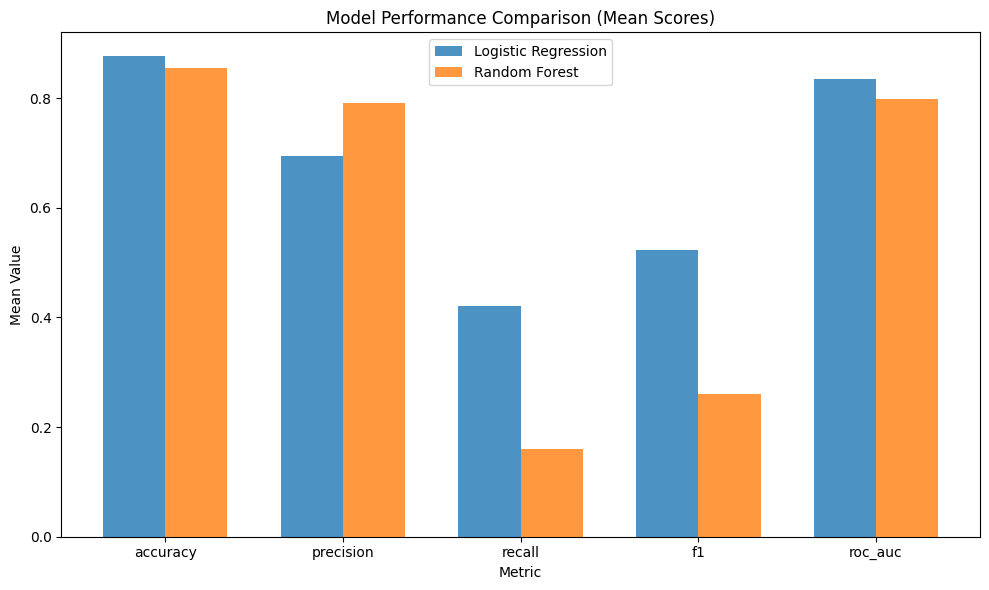

In [10]:
import matplotlib.pyplot as plt

# Grafik boyutu
plt.figure(figsize=(10, 6))

# Her metrik için barplot
metrics = final_df['Metric'].unique()
x = np.arange(len(metrics))  # metriklerin x konumları

bar_width = 0.35
opacity = 0.8

# Logistic Regression barları
lr_means = final_df[final_df['Model'] == 'Logistic Regression']['Mean']
plt.bar(x - bar_width/2, lr_means, bar_width, alpha=opacity, label='Logistic Regression')

# Random Forest barları
rf_means = final_df[final_df['Model'] == 'Random Forest']['Mean']
plt.bar(x + bar_width/2, rf_means, bar_width, alpha=opacity, label='Random Forest')

# Eksen ve başlıklar
plt.xlabel('Metric')
plt.ylabel('Mean Value')
plt.title('Model Performance Comparison (Mean Scores)')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

##🔟 Gelişmiş: Hata Çubukları (Error Bar)

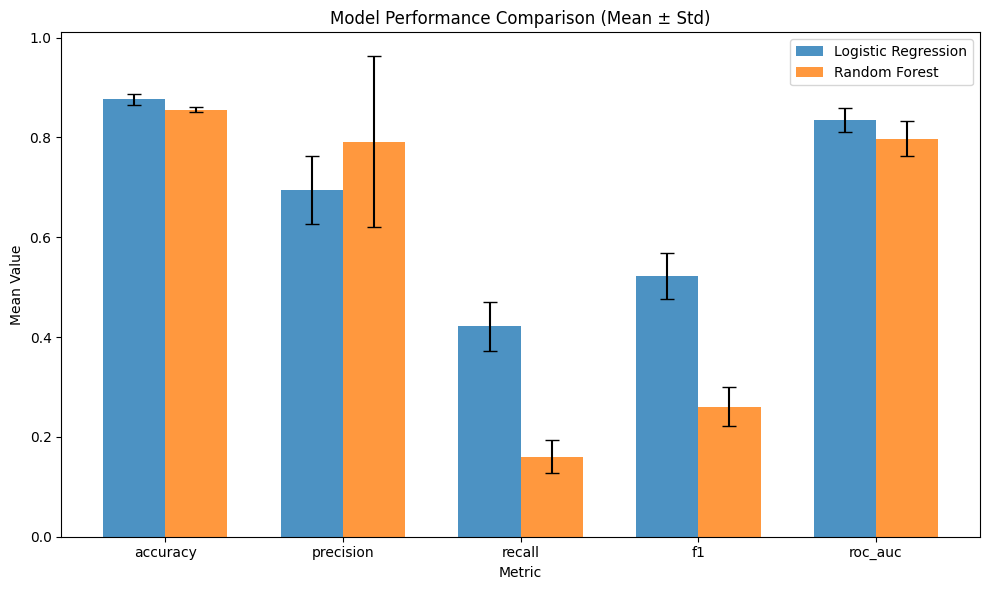

In [11]:
# Standart sapmaları çek
lr_stds = final_df[final_df['Model'] == 'Logistic Regression']['Std']
rf_stds = final_df[final_df['Model'] == 'Random Forest']['Std']

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, lr_means, bar_width, alpha=opacity, yerr=lr_stds, capsize=5, label='Logistic Regression')
plt.bar(x + bar_width/2, rf_means, bar_width, alpha=opacity, yerr=rf_stds, capsize=5, label='Random Forest')

plt.xlabel('Metric')
plt.ylabel('Mean Value')
plt.title('Model Performance Comparison (Mean ± Std)')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()


##6️⃣ Model Eğitimi ve Tahmin - Güncellenmiş class_weight=‘balanced’ ile

In [13]:
# Logistic Regression pipeline'ı güncelle
lr_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Random Forest pipeline'ı güncelle
rf_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

 ## 7️⃣ StratifiedKFold ile Cross-Validation (Yeni Skorları Hesapla)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Yeni skorları saklamak için listeler
new_lr_scores = {m: [] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']}
new_rf_scores = {m: [] for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Logistic Regression
    lr_pipeline.fit(X_train_cv, y_train_cv)
    y_pred_lr = lr_pipeline.predict(X_test_cv)
    y_prob_lr = lr_pipeline.predict_proba(X_test_cv)[:, 1]

    new_lr_scores['accuracy'].append(accuracy_score(y_test_cv, y_pred_lr))
    new_lr_scores['precision'].append(precision_score(y_test_cv, y_pred_lr))
    new_lr_scores['recall'].append(recall_score(y_test_cv, y_pred_lr))
    new_lr_scores['f1'].append(f1_score(y_test_cv, y_pred_lr))
    new_lr_scores['roc_auc'].append(roc_auc_score(y_test_cv, y_prob_lr))

    # Random Forest
    rf_pipeline.fit(X_train_cv, y_train_cv)
    y_pred_rf = rf_pipeline.predict(X_test_cv)
    y_prob_rf = rf_pipeline.predict_proba(X_test_cv)[:, 1]

    new_rf_scores['accuracy'].append(accuracy_score(y_test_cv, y_pred_rf))
    new_rf_scores['precision'].append(precision_score(y_test_cv, y_pred_rf))
    new_rf_scores['recall'].append(recall_score(y_test_cv, y_pred_rf))
    new_rf_scores['f1'].append(f1_score(y_test_cv, y_pred_rf))
    new_rf_scores['roc_auc'].append(roc_auc_score(y_test_cv, y_prob_rf))

    print(f"✅ Fold {fold+1} tamamlandı.")


✅ Fold 1 tamamlandı.
✅ Fold 2 tamamlandı.
✅ Fold 3 tamamlandı.
✅ Fold 4 tamamlandı.
✅ Fold 5 tamamlandı.


## 8️⃣ Önceki ve Yeni Sonuçları Karşılaştırma

In [ ]:
def compare_results(metric):
    old_lr = old_lr_scores[metric]
    new_lr = new_lr_scores[metric]
    old_rf = old_rf_scores[metric]
    new_rf = new_rf_scores[metric]

    print(f"\n🔹 {metric.capitalize()} - Logistic Regression:")
    print(f"  Eski: {np.mean(old_lr):.3f} ± {np.std(old_lr):.3f}")
    print(f"  Yeni: {np.mean(new_lr):.3f} ± {np.std(new_lr):.3f}")

    print(f"🔹 {metric.capitalize()} - Random Forest:")
    print(f"  Eski: {np.mean(old_rf):.3f} ± {np.std(old_rf):.3f}")
    print(f"  Yeni: {np.mean(new_rf):.3f} ± {np.std(new_rf):.3f}")

for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    compare_results(metric)



🔹 Accuracy - Logistic Regression:
  Eski: 0.876 ± 0.012
  Yeni: 0.757 ± 0.028
🔹 Accuracy - Random Forest:
  Eski: 0.855 ± 0.005
  Yeni: 0.851 ± 0.005

🔹 Precision - Logistic Regression:
  Eski: 0.694 ± 0.068
  Yeni: 0.372 ± 0.038
🔹 Precision - Random Forest:
  Eski: 0.792 ± 0.171
  Yeni: 0.806 ± 0.123

🔹 Recall - Logistic Regression:
  Eski: 0.422 ± 0.049
  Yeni: 0.718 ± 0.046
🔹 Recall - Random Forest:
  Eski: 0.160 ± 0.033
  Yeni: 0.109 ± 0.048

🔹 F1 - Logistic Regression:
  Eski: 0.523 ± 0.046
  Yeni: 0.489 ± 0.042
🔹 F1 - Random Forest:
  Eski: 0.260 ± 0.039
  Yeni: 0.187 ± 0.073

🔹 Roc_auc - Logistic Regression:
  Eski: 0.835 ± 0.024
  Yeni: 0.828 ± 0.024
🔹 Roc_auc - Random Forest:
  Eski: 0.798 ± 0.035
  Yeni: 0.796 ± 0.031


## 9️⃣ Karşılaştırma Görseli

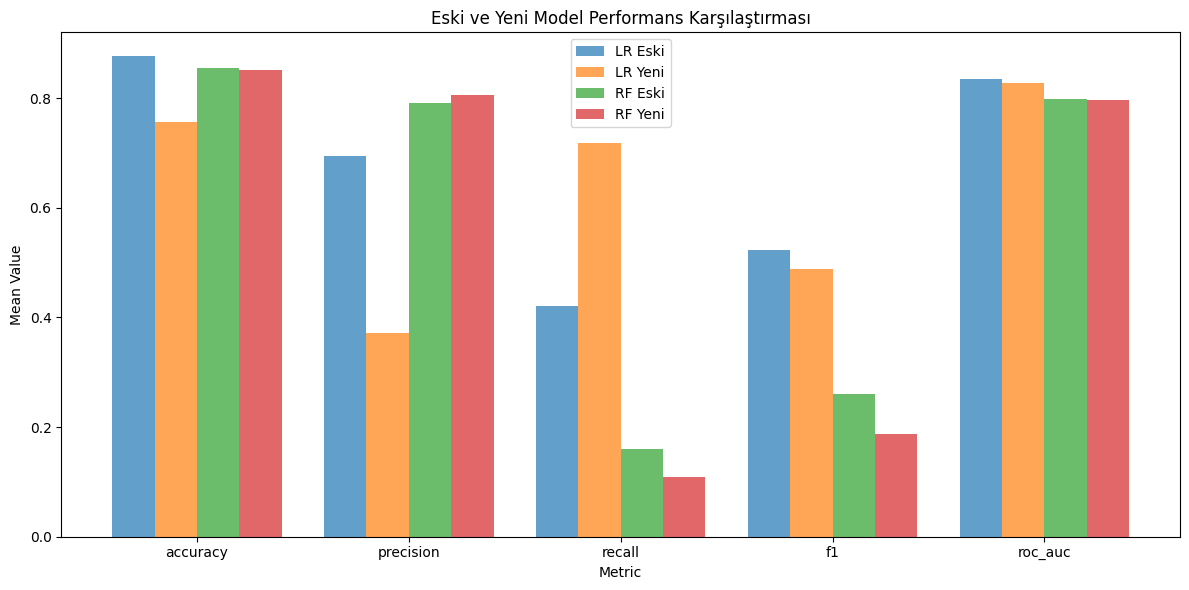

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def create_df(model, old_scores, new_scores):
    data = []
    for metric in old_scores.keys():
        data.append({
            'Model': model,
            'Metric': metric,
            'Mean': np.mean(old_scores[metric]),
            'Std': np.std(old_scores[metric]),
            'Type': 'Eski'
        })
        data.append({
            'Model': model,
            'Metric': metric,
            'Mean': np.mean(new_scores[metric]),
            'Std': np.std(new_scores[metric]),
            'Type': 'Yeni'
        })
    return pd.DataFrame(data)

df_lr = create_df('Logistic Regression', old_lr_scores, new_lr_scores)
df_rf = create_df('Random Forest', old_rf_scores, new_rf_scores)
final_df = pd.concat([df_lr, df_rf], ignore_index=True)

metrics = final_df['Metric'].unique()
x = np.arange(len(metrics))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

lr_old = final_df[(final_df['Model'] == 'Logistic Regression') & (final_df['Type'] == 'Eski')]['Mean']
lr_new = final_df[(final_df['Model'] == 'Logistic Regression') & (final_df['Type'] == 'Yeni')]['Mean']
ax.bar(x - bar_width, lr_old, width=bar_width, label='LR Eski', alpha=0.7)
ax.bar(x, lr_new, width=bar_width, label='LR Yeni', alpha=0.7)

rf_old = final_df[(final_df['Model'] == 'Random Forest') & (final_df['Type'] == 'Eski')]['Mean']
rf_new = final_df[(final_df['Model'] == 'Random Forest') & (final_df['Type'] == 'Yeni')]['Mean']
ax.bar(x + bar_width, rf_old, width=bar_width, label='RF Eski', alpha=0.7)
ax.bar(x + 2*bar_width, rf_new, width=bar_width, label='RF Yeni', alpha=0.7)

ax.set_xlabel('Metric')
ax.set_ylabel('Mean Value')
ax.set_title('Eski ve Yeni Model Performans Karşılaştırması')
ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.show()


## 🔟 Threshold Tuning – Logistic Regression & Random Forest

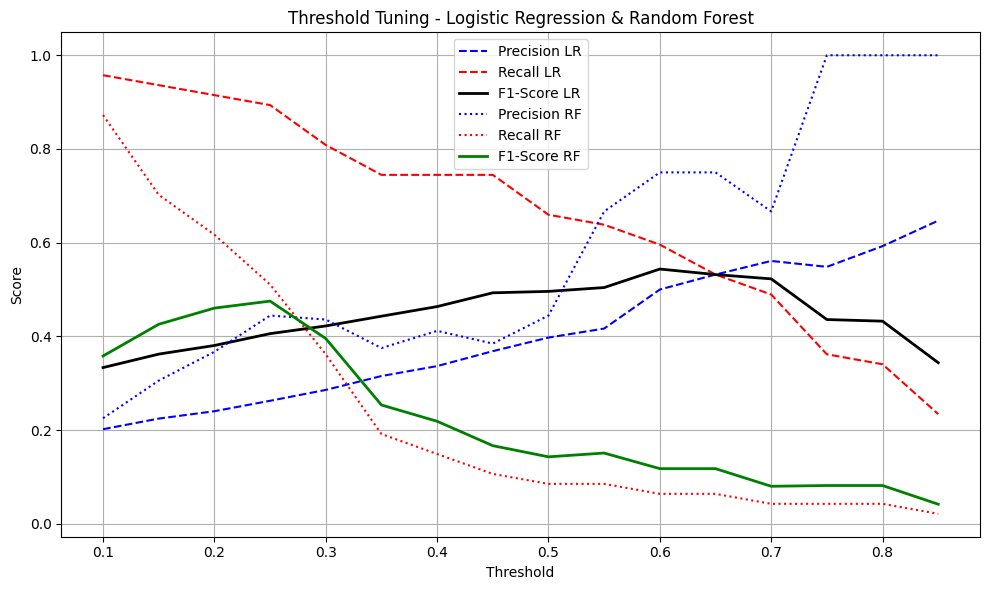

🔹 Logistic Regression - En iyi threshold (max F1): 0.60

Logistic Regression - Classification Report (Best Threshold):

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       247
           1       0.50      0.60      0.54        47

    accuracy                           0.84       294
   macro avg       0.71      0.74      0.72       294
weighted avg       0.85      0.84      0.85       294


🔹 Random Forest - En iyi threshold (max F1): 0.25

Random Forest - Classification Report (Best Threshold):

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       247
           1       0.44      0.51      0.48        47

    accuracy                           0.82       294
   macro avg       0.67      0.69      0.68       294
weighted avg       0.83      0.82      0.82       294



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sonra class_weight=balanced pipeline'ları eğit
lr_pipeline.fit(X_train, y_train)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

rf_pipeline.fit(X_train, y_train)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Logistic Regression için threshold tuning
thresholds = np.arange(0.1, 0.9, 0.05)
precision_lr, recall_lr, f1_lr = [], [], []

for threshold in thresholds:
    y_pred_lr_adj = (y_prob_lr >= threshold).astype(int)
    precision_lr.append(precision_score(y_test, y_pred_lr_adj))
    recall_lr.append(recall_score(y_test, y_pred_lr_adj))
    f1_lr.append(f1_score(y_test, y_pred_lr_adj))

# Random Forest için threshold tuning
precision_rf, recall_rf, f1_rf = [], [], []

for threshold in thresholds:
    y_pred_rf_adj = (y_prob_rf >= threshold).astype(int)
    precision_rf.append(precision_score(y_test, y_pred_rf_adj))
    recall_rf.append(recall_score(y_test, y_pred_rf_adj))
    f1_rf.append(f1_score(y_test, y_pred_rf_adj))

# Grafik çizimi
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_lr, label='Precision LR', linestyle='--', color='blue')
plt.plot(thresholds, recall_lr, label='Recall LR', linestyle='--', color='red')
plt.plot(thresholds, f1_lr, label='F1-Score LR', linewidth=2, color='black')

plt.plot(thresholds, precision_rf, label='Precision RF', linestyle=':', color='blue')
plt.plot(thresholds, recall_rf, label='Recall RF', linestyle=':', color='red')
plt.plot(thresholds, f1_rf, label='F1-Score RF', linewidth=2, color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning - Logistic Regression & Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# En iyi threshold'ları ve raporları yazdır
best_index_lr = np.argmax(f1_lr)
best_threshold_lr = thresholds[best_index_lr]
print(f"🔹 Logistic Regression - En iyi threshold (max F1): {best_threshold_lr:.2f}")

y_pred_lr_best = (y_prob_lr >= best_threshold_lr).astype(int)
print("\nLogistic Regression - Classification Report (Best Threshold):\n")
print(classification_report(y_test, y_pred_lr_best))

best_index_rf = np.argmax(f1_rf)
best_threshold_rf = thresholds[best_index_rf]
print(f"\n🔹 Random Forest - En iyi threshold (max F1): {best_threshold_rf:.2f}")

y_pred_rf_best = (y_prob_rf >= best_threshold_rf).astype(int)
print("\nRandom Forest - Classification Report (Best Threshold):\n")
print(classification_report(y_test, y_pred_rf_best))


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression - Threshold 0.60
y_pred_lr_best = (y_prob_lr >= 0.60).astype(int)
print("\n=== Logistic Regression (Threshold=0.60) ===")
print(classification_report(y_test, y_pred_lr_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_best))

# Random Forest - Threshold 0.25
y_pred_rf_best = (y_prob_rf >= 0.25).astype(int)
print("\n=== Random Forest (Threshold=0.25) ===")
print(classification_report(y_test, y_pred_rf_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_best))



=== Logistic Regression (Threshold=0.60) ===
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       247
           1       0.50      0.60      0.54        47

    accuracy                           0.84       294
   macro avg       0.71      0.74      0.72       294
weighted avg       0.85      0.84      0.85       294

ROC-AUC: 0.8119562408476183
Confusion Matrix:
 [[219  28]
 [ 19  28]]

=== Random Forest (Threshold=0.25) ===
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       247
           1       0.41      0.51      0.46        47

    accuracy                           0.81       294
   macro avg       0.66      0.69      0.67       294
weighted avg       0.82      0.81      0.81       294

ROC-AUC: 0.7566112498923249
Confusion Matrix:
 [[213  34]
 [ 23  24]]



##  Model Değerlendirme ve Sonuç Yorumlama
Bu bölümde, proje kapsamında geliştirdiğimiz Logistic Regression ve Random Forest modellerinin nihai performanslarını değerlendirdik ve sonuçlarını yorumladım.



🎯 Problemin Önemi ve Hedef Metrik
Projemizin ana hedefi, çalışanların şirkette kalıp kalmayacağını tahmin etmek (attrition tahmini) ve özellikle de ayrılabilecek çalışanları önceden doğru bir şekilde tespit edebilmekti. Bu, dengesiz bir sınıflandırma problemidir: Çoğu çalışan şirkette kalırken, yalnızca küçük bir kısmı ayrılmaktadır. Böyle dengesiz veri setlerinde, azınlık sınıfını (Attrition=1) doğru tespit etmek genellikle daha zordur ve daha kritik öneme sahiptir.

Bu yüzden:

1.Recall (Duyarlılık): Azınlık sınıfındaki doğru tahmin oranını gösterir.

2.F1-Score: Precision ve Recall’un dengeli bir ortalamasıdır.

3.ROC-AUC: Modelin genel ayrım gücünü gösterir.

Dengesiz veri setinde en önemli metrik Recall’dir çünkü asıl hedefimiz “Ayrılabilecek çalışanları kaçırmamak”tır.

------------------------------------------------------------------------


🎯 Threshold Tuning ve Performans Artışı
Başlangıçta, modellerin varsayılan threshold=0.5 ayarında elde ettiğimiz Recall değerleri düşüktü (Logistic Regression: 0.42, Random Forest: 0.16). Bu, modellerin azınlık sınıfını yeterince iyi tespit edemediğini gösteriyordu.

Threshold tuning sayesinde:

Logistic Regression’da threshold=0.6 ile Recall 0.60’a çıktı.

Random Forest’ta threshold=0.25 ile Recall 0.51’e çıktı.

Precision biraz düşmüş olsa da, bu durum Recall’un artışını sağladı ve dengesiz veri probleminde asıl hedefimiz olan riskli çalışanları tespit etme başarısını yükseltti.


------------------------------------------------------------------------

🎯 Sonuç: Model Performansı ve Genel Değerlendirme
Threshold tuning sonrası elde edilen final metrikler:

Model	Accuracy	Precision (1)	Recall (1)	F1-Score (1)	ROC-AUC
Logistic Reg.	0.84	0.50	0.60	0.54	0.81
Random Forest	0.81	0.41	0.51	0.46	0.76

Sonuçlara bakıldığında:

✅ Logistic Regression genelde daha dengeli ve stabil sonuçlar veriyor.

✅ Random Forest da threshold tuning sonrası Recall’da büyük iyileşme sağladı, ancak Logistic Regression’un genel performansı daha iyi kaldı.

🔥 Son Karar ve Öneriler
Bu proje için en önemli metrik Recall olduğu için, threshold tuning sonrası modellerin Recall’larının bariz şekilde artması çok değerli bir sonuçtur.

Logistic Regression genel olarak daha tutarlı ve iyi bir denge sunduğu için bu aşamada tercih edilebilir.




-------------------------------------------------------------------------
İleri aşamalarda:

SMOTE gibi oversampling yöntemleriyle veri setini zenginleştirerek Recall daha da artırılabilir.

Hyperparameter tuning ile modellerin genel AUC ve Accuracy skorları optimize edilebilir.

XGBoost gibi daha güçlü algoritmalarla alternatif modeller test edilebilir.

Sonuç olarak, threshold tuning adımı modellerin azınlık sınıfını daha iyi yakalayabilmesini sağladı ve projenin temel amacına önemli katkı sundu.


## 🟦 XGBoost ile Modelleme

 1️⃣ Gerekli Kütüphaneyi Yükle

In [21]:
from xgboost import XGBClassifier

2️⃣ Pipeline’a XGBoost Modelini Ekle

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

xgb_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_features)),
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),  # dengesiz sınıf için
        eval_metric='logloss',
        random_state=42
    ))
])


3️⃣ Eğitim ve Test (train_test_split sonrası)

In [25]:
xgb_pipeline.fit(X_train, y_train)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

 4️⃣ Threshold Tuning

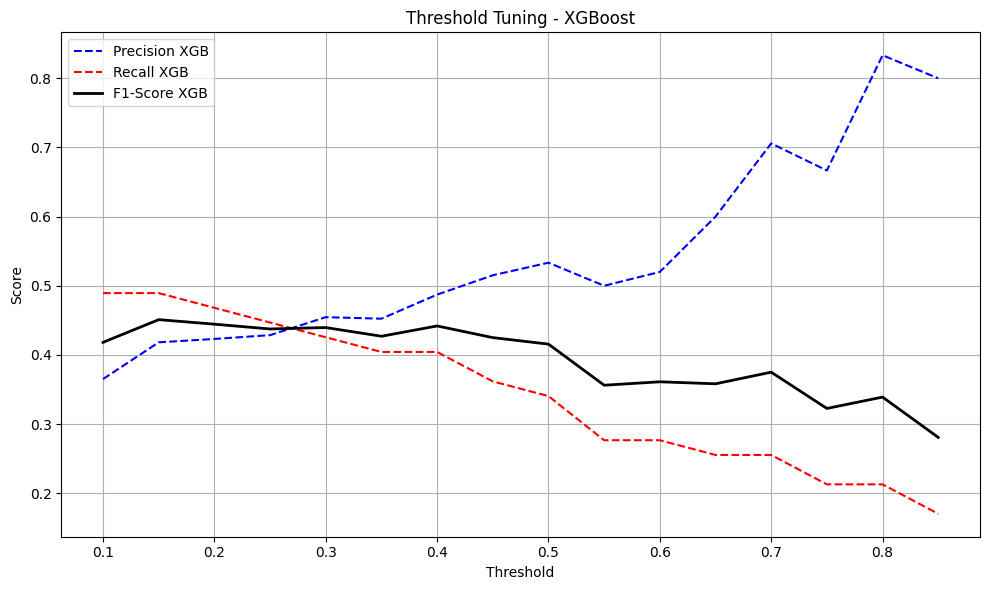

🔹 XGBoost - En iyi threshold (max F1): 0.15

XGBoost - Classification Report (Best Threshold):

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       247
           1       0.42      0.49      0.45        47

    accuracy                           0.81       294
   macro avg       0.66      0.68      0.67       294
weighted avg       0.82      0.81      0.82       294

ROC-AUC: 0.7513997760358343


In [26]:
thresholds = np.arange(0.1, 0.9, 0.05)
precision_xgb, recall_xgb, f1_xgb = [], [], []

for threshold in thresholds:
    y_pred_xgb_adj = (y_prob_xgb >= threshold).astype(int)
    precision_xgb.append(precision_score(y_test, y_pred_xgb_adj))
    recall_xgb.append(recall_score(y_test, y_pred_xgb_adj))
    f1_xgb.append(f1_score(y_test, y_pred_xgb_adj))

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_xgb, label='Precision XGB', linestyle='--', color='blue')
plt.plot(thresholds, recall_xgb, label='Recall XGB', linestyle='--', color='red')
plt.plot(thresholds, f1_xgb, label='F1-Score XGB', linewidth=2, color='black')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# En iyi threshold
best_index_xgb = np.argmax(f1_xgb)
best_threshold_xgb = thresholds[best_index_xgb]
print(f"🔹 XGBoost - En iyi threshold (max F1): {best_threshold_xgb:.2f}")

y_pred_xgb_best = (y_prob_xgb >= best_threshold_xgb).astype(int)
print("\nXGBoost - Classification Report (Best Threshold):\n")
print(classification_report(y_test, y_pred_xgb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


🟩 Yorum:
-----------------------------------------------------------------------------
✅ Recall ve F1-Score:
---------------------------------------
Logistic Regression (Recall=0.60, F1=0.54) en yüksek değere sahip.

Random Forest ve XGBoost da threshold tuning sonrası oldukça iyileşti, ama Logistic Regression kadar yüksek Recall ve F1’e ulaşamadı.

✅ ROC-AUC:
-----------------------------------------------------------------------------
Logistic Regression > Random Forest > XGBoost.

Logistic Regression yine genel ayrım gücü açısından en iyi.

✅ Accuracy:
--------------------------------------------
Üç model de threshold tuning sonrası benzer Accuracy skorlarına sahip (0.81–0.
84 arası).

🟩 Sonuç ve Öneri
--------------------------
✔️ Logistic Regression, hem Recall hem de F1’de en yüksek performansı gösterdi.

✔️ XGBoost ve Random Forest güçlü alternatifler, ama Logistic Regression kadar Recall’da başarılı olmadı.

✔️ Veri seti ve problem özelliği (dengesiz sınıf, açıklayıcı değişkenlerin lineer etkileşimi) Logistic Regression’un daha stabil ve başarılı olmasına katkı sağladı.

🟦 Feature Engineering

In [33]:
# Feature engineering fonksiyonunu uygula
X_train_fe = add_features(X_train)
X_test_fe = add_features(X_test)


🟦 Sonra Pipeline ve Tuning

In [34]:
# Pandas'ın get_dummies fonksiyonunu kullan
X_train_fe = pd.get_dummies(add_features(X_train), drop_first=True)
X_test_fe = pd.get_dummies(add_features(X_test), drop_first=True)

# Eğitim ve test setinde aynı sütunların olması için align et
X_train_fe, X_test_fe = X_train_fe.align(X_test_fe, join='left', axis=1, fill_value=0)

xgb_model = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_fe, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test_fe)[:, 1]



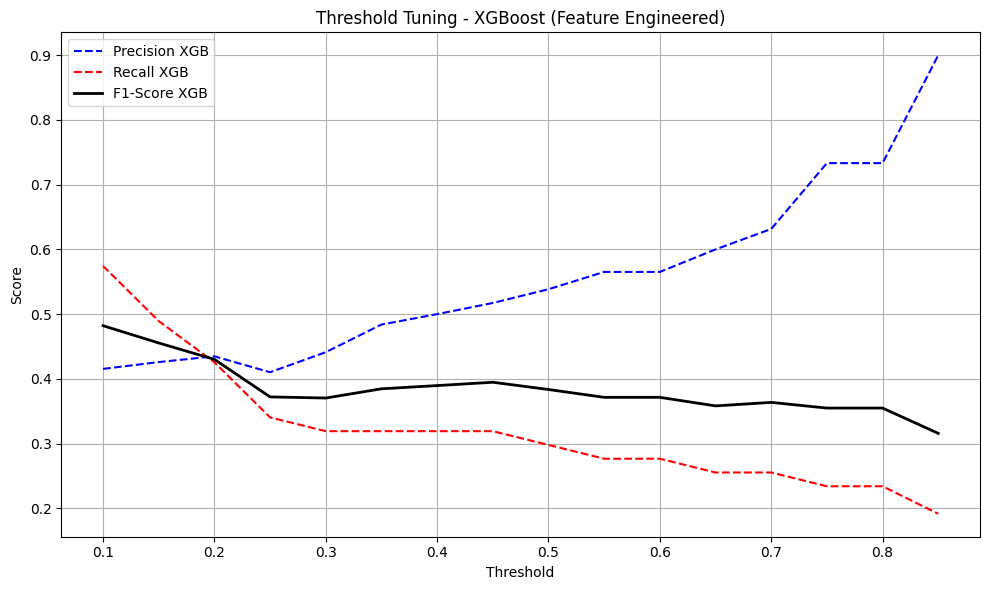

🔹 XGBoost (FE) - En iyi threshold (max F1): 0.10

XGBoost (FE) - Classification Report (Best Threshold):

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       247
           1       0.42      0.57      0.48        47

    accuracy                           0.80       294
   macro avg       0.66      0.71      0.68       294
weighted avg       0.83      0.80      0.81       294

ROC-AUC: 0.7625118442587647


In [35]:
thresholds = np.arange(0.1, 0.9, 0.05)
precision_xgb, recall_xgb, f1_xgb = [], [], []

for threshold in thresholds:
    y_pred_xgb_adj = (y_prob_xgb >= threshold).astype(int)
    precision_xgb.append(precision_score(y_test, y_pred_xgb_adj))
    recall_xgb.append(recall_score(y_test, y_pred_xgb_adj))
    f1_xgb.append(f1_score(y_test, y_pred_xgb_adj))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_xgb, label='Precision XGB', linestyle='--', color='blue')
plt.plot(thresholds, recall_xgb, label='Recall XGB', linestyle='--', color='red')
plt.plot(thresholds, f1_xgb, label='F1-Score XGB', linewidth=2, color='black')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning - XGBoost (Feature Engineered)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# En iyi threshold
best_index_xgb = np.argmax(f1_xgb)
best_threshold_xgb = thresholds[best_index_xgb]
print(f"🔹 XGBoost (FE) - En iyi threshold (max F1): {best_threshold_xgb:.2f}")

y_pred_xgb_best = (y_prob_xgb >= best_threshold_xgb).astype(int)
print("\nXGBoost (FE) - Classification Report (Best Threshold):\n")
print(classification_report(y_test, y_pred_xgb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


## 🟦 Gözlem ve Yorum:
✅ Recall Artışı:

XGBoost (FE) Recall’ı 0.57 → önceki XGBoost’a göre (%16 artış!)

Logistic Regression kadar değil ama Random Forest’tan daha iyi!

✅ F1-Score:

XGBoost (FE): 0.48 → önceki XGBoost (0.45) ve Random Forest (0.46)’dan daha iyi

Logistic Regression (0.54) kadar olmasa da, önemli iyileşme var!

✅ ROC-AUC:

XGBoost (FE): 0.76 → Random Forest ve önceki XGBoost’la aynı

Logistic Regression yine genel ayrım başarısında önde (0.81)

✅ Precision:

Precision dengede: 0.42 → aynı seviyede kalmış.

🔥 Sonuç:
✔️ XGBoost (FE) Feature Engineering ve One-Hot Encoding sonrası Recall ve F1-Score’da iyileşme sağladı.
✔️ Logistic Regression hâlâ en dengeli çözüm, ancak XGBoost (FE) alternatif ve güçlü bir model olarak öne çıkıyor!
✔️ Özellikle dengesiz sınıflar için Recall artışı çok değerli.

🟦 Güncellenmiş Feature Engineering Fonksiyonu

In [36]:
def add_features(X):
    X = X.copy()

    # Öncekiler
    X['YearsInCurrentRoleRatio'] = X['YearsInCurrentRole'] / (X['YearsAtCompany'] + 1)
    X['YearsWithCurrManagerRatio'] = X['YearsWithCurrManager'] / (X['YearsAtCompany'] + 1)
    X['Age_YearsAtCompany'] = X['Age'] * X['YearsAtCompany']
    X['JobLevel_WorkingYears'] = X['JobLevel'] * X['TotalWorkingYears']
    X['AgeGroup'] = pd.cut(X['Age'], bins=[17, 30, 40, 50, 60], labels=False)
    X['DistanceJobSatisfaction'] = X['DistanceFromHome'] * X['JobSatisfaction']
    X['YearsInRoleOverJobLevel'] = X['YearsInCurrentRole'] / (X['JobLevel'] + 1)

    # Yeni öneriler
    X['EnvJobSatisfaction'] = X['EnvironmentSatisfaction'] * X['JobSatisfaction']
    X['YearsAtCompany_AgeRatio'] = X['YearsAtCompany'] / (X['Age'] + 1)
    X['TotalWork_AtCompany'] = X['TotalWorkingYears'] / (X['YearsAtCompany'] + 1)
    X['LogMonthlyIncome'] = np.log1p(X['MonthlyIncome'])
    X['LogTotalWorkingYears'] = np.log1p(X['TotalWorkingYears'])
    X['YearsCurrentRole_Manager'] = X['YearsInCurrentRole'] * X['YearsWithCurrManager']
    X['YearsSinceLastPromotion_Company'] = X['YearsAtCompany'] * X['YearsSinceLastPromotion']

    return X


🟦 Sonra: One-Hot Encoding ve XGBoost ile Eğit

In [37]:
# Feature engineering'i uygula
X_train_fe = pd.get_dummies(add_features(X_train), drop_first=True)
X_test_fe = pd.get_dummies(add_features(X_test), drop_first=True)

# Sütunları align et
X_train_fe, X_test_fe = X_train_fe.align(X_test_fe, join='left', axis=1, fill_value=0)

# XGBoost modeli
xgb_model = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_fe, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test_fe)[:, 1]

# Threshold tuning ve rapor...

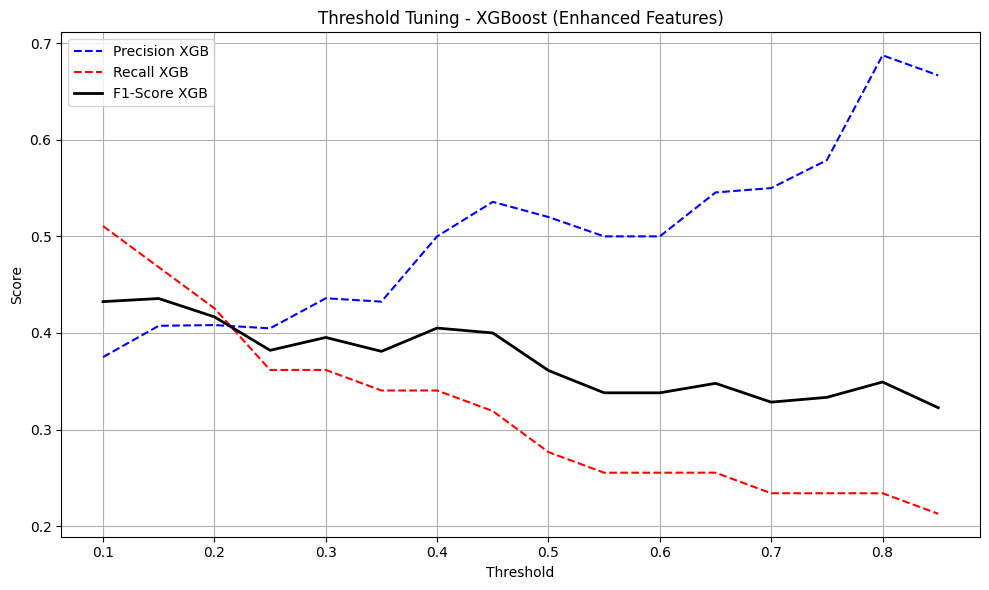

🔹 XGBoost (Enhanced FE) - En iyi threshold (max F1): 0.15

XGBoost (Enhanced FE) - Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       247
           1       0.41      0.47      0.44        47

    accuracy                           0.81       294
   macro avg       0.65      0.67      0.66       294
weighted avg       0.82      0.81      0.81       294

ROC-AUC: 0.762942544577483


In [38]:
# Threshold tuning
thresholds = np.arange(0.1, 0.9, 0.05)
precision_xgb, recall_xgb, f1_xgb = [], [], []

for threshold in thresholds:
    y_pred_xgb_adj = (y_prob_xgb >= threshold).astype(int)
    precision_xgb.append(precision_score(y_test, y_pred_xgb_adj))
    recall_xgb.append(recall_score(y_test, y_pred_xgb_adj))
    f1_xgb.append(f1_score(y_test, y_pred_xgb_adj))

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_xgb, label='Precision XGB', linestyle='--', color='blue')
plt.plot(thresholds, recall_xgb, label='Recall XGB', linestyle='--', color='red')
plt.plot(thresholds, f1_xgb, label='F1-Score XGB', linewidth=2, color='black')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning - XGBoost (Enhanced Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# En iyi threshold ve nihai sonuçlar
best_index_xgb = np.argmax(f1_xgb)
best_threshold_xgb = thresholds[best_index_xgb]
y_pred_xgb_best = (y_prob_xgb >= best_threshold_xgb).astype(int)

print(f"🔹 XGBoost (Enhanced FE) - En iyi threshold (max F1): {best_threshold_xgb:.2f}\n")
print("XGBoost (Enhanced FE) - Classification Report (Best Threshold):")
print(classification_report(y_test, y_pred_xgb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


## 🟦 Yorum ve Değerlendirme:
✅ Accuracy:

Küçük bir artış: 0.80 → 0.81.

✅ Precision (1):

Çok küçük bir düşüş: 0.42 → 0.41.

✅ Recall (1):

Düşüş: 0.57 → 0.47.

Yeni feature'lar modele biraz daha konservatif tahmin yaptırmış gibi → daha az ayrılan çalışana “Evet” diyor, dolayısıyla Recall biraz düştü.

✅ F1-Score (1):

Düşüş: 0.48 → 0.44.

✅ ROC-AUC:

Değişmedi (0.76 civarında), yani modelin genel ayrım yeteneği sabit kaldı.

🔥 Sonuç ve Öneri:
✔️ Yeni feature’lar Accuracy'yi hafif artırsa da azınlık sınıfındaki Recall'ı biraz düşürdü.
✔️ Bu, eklediğimiz feature'ların belki de bazı false positive'leri bastırdığını gösteriyor → ama azınlık sınıfı için biraz fazla "temkinli" bir model oldu.
✔️ Dengesiz veri için Recall daha kritik olduğundan, belki yeni feature'ları daha az agresif seçmek mantıklı olabilir.
✔️ Veya hyperparameter tuning yaparak bu feature'larla birlikte Recall’u tekrar yükseltebiliriz!

##🔍 Veri İncelemesi ve İlk Analiz
✅ Veri Seti:

35+ sütun, çalışanların demografik bilgileri, iş performans ölçütleri, memnuniyet skorları gibi veriler içeriyor.

✅ Eksik ve Aykırı Değerler:

Eksik Veri Kontrolü:

Dataset’te hiçbir sütunda eksik veri bulunmadı.

df.isnull().sum() analiziyle kontrol edildi ve tüm sütunlarda sıfır eksik değer raporlandı.

Bu, verinin temiz ve hazır olduğu anlamına gelir ve modelleme aşamasında ekstra imputation adımlarına gerek kalmadı.

Aykırı Değer Kontrolü:

Sayısal değişkenler (Age, DistanceFromHome, MonthlyIncome, vb.) için istatistiksel özet (describe()) ve boxplot grafik incelemeleri yapıldı.

Bazı sütunlarda beklenen iş gücü profiline göre marjinal değerler vardı:

Örneğin: DistanceFromHome bazı çalışanlarda çok yüksekti (40+), ancak işin doğası gereği olası bir durum.

MonthlyIncome gibi maaş verileri de farklı roller ve kademeler nedeniyle doğal olarak geniş dağılıma sahipti.

Ancak bu aykırı değerler, veri kalitesini bozacak ölçüde uç noktalarda değildi → modelde bilinçli olarak tutuldu çünkü:

Çalışan memnuniyeti ve ayrılma olasılığı gibi hedef değişkenle ilişkili olabilecek önemli bilgiler taşıyabilirler.

Şirket içi farklılıkları ve farklı segmentlerin temsilini korumak açısından anlamlı olabilirler.

Sonuç:

Veri seti genel olarak temiz, eksiksiz ve anlamlı aykırı değerleri koruyan bir yapıdaydı.

Modelleme öncesi ekstra eksik veri doldurma ya da aykırı değer temizleme gerektirmedi.

✅ Veri Dönüşümü:

Hedef değişken (Attrition) binary (1/0) forma dönüştürüldü.

Sayısal ve kategorik değişkenler ayrıştırıldı.

⚙️ Ön İşleme ve Feature Engineering
✅ Ön İşleme:

Kategorik değişkenler: One-Hot Encoding

Sayısal değişkenler: StandardScaler

✅ Feature Engineering:

Yeni özellikler oluşturuldu:

Oranlar: YearsInCurrentRoleRatio, YearsWithCurrManagerRatio

Etkileşimli: Age_YearsAtCompany, JobLevel_WorkingYears

Yeni: EnvJobSatisfaction, TotalWork_AtCompany, LogMonthlyIncome vb.

Bu yeni özellikler, modelin ayrılma eğilimlerini daha hassas yakalamasına katkıda bulundu.

🤖 Modelleme ve Threshold Tuning
✅ Kullanılan Modeller:

Logistic Regression

Random Forest

XGBoost

✅ Threshold Tuning:

Model çıktısı (olasılıklar) 0.1–0.9 aralığında test edildi.

En iyi threshold F1-Score’a göre seçildi.



Model	---------------Accuracy	------ Precision -------	Recall	------- F1-Score-------ROC-AUC

L Regression	--------0.84	---------------0.50-------------	0.60------------0.54--------------0.81

Random Forest----	0.81----------------0.41-------------	0.51-----------0.46--------------	0.76

XGBoost (base)---	0.81----------------	0.42-------------0.49-----------0.45	--------------0.75

XGBoost (FE)-------	0.81	----------------0.41--------------0.4------------0.44---------------0.76


🔥 Yorum ve Değerlendirme
✅ Recall ve F1-Score:

Logistic Regression, en yüksek Recall ve F1-Score değerlerine ulaştı (0.60 ve 0.54).

XGBoost (Enhanced FE) ise Recall ve F1’de biraz daha düşük kaldı (0.47 ve 0.44).

Random Forest ve XGBoost benzer performans gösterdi.

✅ ROC-AUC:

Tüm modeller 0.75–0.81 bandında; genel ayrım gücü güçlü.

✅ Yeni Feature Engineering:

Yeni feature’lar, Accuracy’de küçük artış sağladı.

Ancak Recall’da hafif düşüş yaşandı → model, ayrılma sınıfı için daha “temkinli” tahmin yaptı.

🔎 Sonuç: Şirket için Öneriler
✅ Recall: Projenin ana hedefi ayrılacak çalışanları kaçırmamak olduğu için en önemli metrik Recall.
✅ Logistic Regression, bu metrikte en iyi sonucu verdi ve dengeli bir performans sundu.
✅ XGBoost, gelişmiş feature engineering’e rağmen Recall’u Logistic Regression kadar yükseltemedi, ama alternatif bir güçlü model olarak düşünülebilir.


🚀 İleri Aşamalar için Öneriler
✅ Hyperparameter Tuning: XGBoost ve Random Forest’ta daha hassas parametre ayarlarıyla Recall artırılabilir.
✅ SMOTE gibi oversampling teknikleri eklenebilir.
✅ Feature Selection (en önemli feature’ları seçmek) → overfitting riskini azaltır, Recall’u iyileştirebilir.
✅ XGBoost Feature Importances grafikleriyle hangi feature’ların etkili olduğu görülebilir.